In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import os
import sys
# Determine the absolute path to your training data folder.
project_root = os.path.abspath(
    os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')
)

# Insert project_root to sys.path if needed.
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Build the path to the data folder (assuming your data folder is directly under the project root)
data_dir = os.path.join(project_root, 'data')
data_small_dir = os.path.join(project_root, 'data_small')

print("Project root:", project_root)
print("Data directory:", data_dir)

from models import get_model, effnetv2b0_base, effnetv2b3_base,train_model

from keras.models import Model
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

Project root: /home/phigep/fh/face-mask-detection
Data directory: /home/phigep/fh/face-mask-detection/data


In [31]:
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
test_small_dir = os.path.join(data_small_dir, 'test')

In [4]:
BATCH_SIZE = 32
ORIGINAL_IMAGE_SIZE = (None, None)  # Allow variable sizes
TARGET_IMAGE_SIZE = (224, 224)       # EfficientNetV2's expected input size
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE

In [32]:
from preprocessing import get_augmented_dataset
train_dataset = get_augmented_dataset(train_dir)
test_dataset = get_augmented_dataset(test_dir,batch_size=1)
test_small_dataset = get_augmented_dataset(test_small_dir,batch_size=1)


Found 107650 files belonging to 2 classes.
Found 18952 files belonging to 2 classes.
Found 1132 files belonging to 2 classes.


In [33]:
enetb0_model = get_model(effnetv2b0_base,input_dim=(224,224,3), resize_dim=(224,224,3), classes=2,classifier_activation="sigmoid")
enetb3_model = get_model(effnetv2b3_base,input_dim=(224,224,3), resize_dim=(224,224,3), classes=2,classifier_activation="sigmoid")


In [34]:
from keras.optimizers import AdamW
optimizer = AdamW(learning_rate=5e-5)

In [35]:
enetb0_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)
enetb3_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

change back to python to train:


enetb0_model,history = train_model(checkpoint_dir="./checkpoints/",
                                   epochs=3,
                                   model=enetb0_model,
                                   train_data=train_dataset,
                                   val_data=test_dataset,
                                   )

In [36]:
from keras.models import load_model
enetb0_model = load_model("./checkpoints/functional_1.h5")

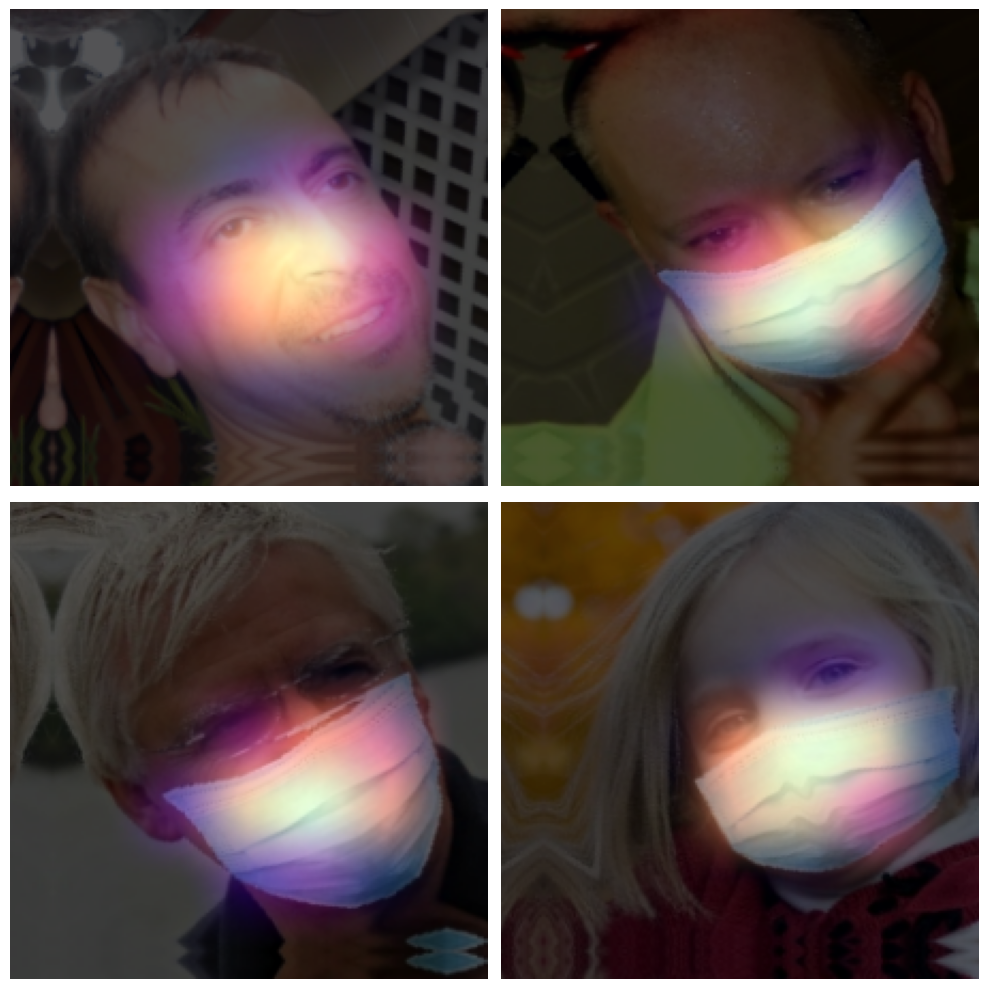

In [53]:
from eval import make_gradcam_heatmap, superimpose_gradcam,plot_images_grid
import matplotlib.pyplot as plt
final_images=[]
for images, labels in test_dataset.take(4):
    heatmap = make_gradcam_heatmap(model=enetb0_model,
                         last_conv_layer_name="efficientnetv2-b0",
                         img_array=images,
                         )
    final = superimpose_gradcam(heatmap=heatmap, img=images[0],alpha=2)
    final_images.append(final)
p=plot_images_grid(final_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0, 1, 1, 0]
[0, 1, 1, 0]


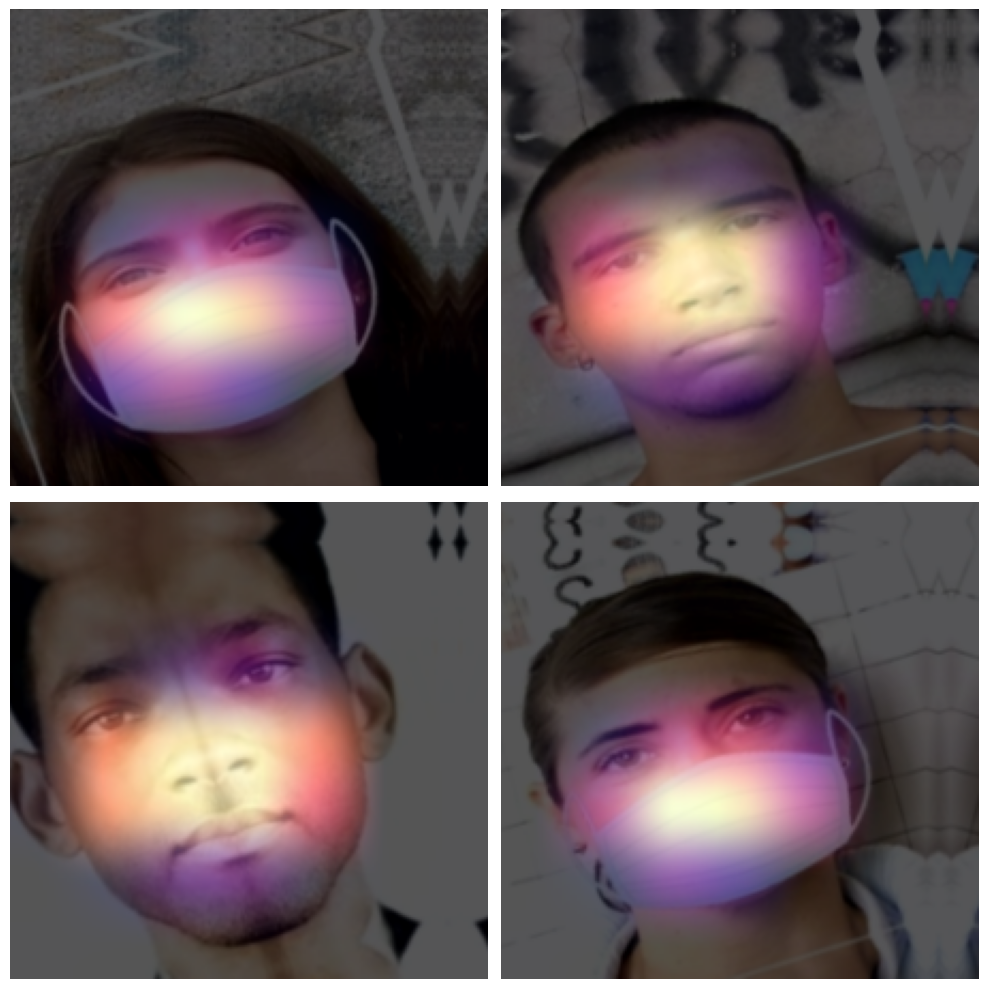

In [77]:
import numpy as np
final_images=[]
preds = []
labels = []
for images, label in test_small_dataset.take(4):
    heatmap = make_gradcam_heatmap(model=enetb0_model,
                         last_conv_layer_name="efficientnetv2-b0",
                         img_array=images,
                         )
    pred= enetb0_model.predict(images)
    preds.append(int(np.argmax(pred)))
    labels.append(int(np.argmax(label)))
    final = superimpose_gradcam(heatmap=heatmap, img=images[0],alpha=2)
    final_images.append(final)
p=plot_images_grid(final_images)
print(labels)
print(preds)